In [67]:
import random
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(12,8)
nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)


## **Постановка задачи:**

Задан граф G=\(V,E\).

Найти клику в G, т.е. подмножество вершин V'⊆V, такое что любая пара вершин в V' соединены ребром из E.

Максимизировать размер клики, т.е. |V'|.



In [68]:
def visme(G, m=None):
    # fig = plt.figure(1, figsize=(800, 640), dpi=60)
    pos = nx.get_node_attributes(G, "pos")
    if not pos:
        pos = nx.spring_layout(G)
    clique = None 
    v_colors = ['green' for _ in G.nodes()] # цвета вершин
    ve_color = ['#ff00ff' for _ in G.nodes()]
    node_sizes = [500 for _ in G.nodes()]
    if m:
        clique = [e for e in m.E if m.x[e[0]]() > 0 and pyo.value(m.x[e[1]])>0]
        val_ = 0
        for i, v in enumerate(G.nodes()):
            if m.x[v].value is not None:
                val_ = m.x[v].value
            if val_ > 0:
                v_colors[i] = 'blue'
                node_sizes[i] = 600


    n_different_clauses = len(set(nx.get_node_attributes(G, 'clause').values()))
    if n_different_clauses:
        p_colors_ = psc.get_hex_palette_for_n(n_different_clauses)
        for i, v in enumerate(G.nodes()):
            clause_ = G.nodes[v].get('clause')
            if clause_ is not None:
                ve_color[i] = p_colors_[clause_]

    labels = {node: G.nodes[node].get('label') or node for node in G.nodes()}

    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        labels=labels,
        edge_color="green",
        node_color=v_colors,
        edgecolors=ve_color,
        linewidths=2,
        node_size=node_sizes,
        style=':',
        width=0.4,
        font_size=8
    )

    if clique:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=clique,
            edge_color="blue",
            node_size=200,
            width=0.7,
        )

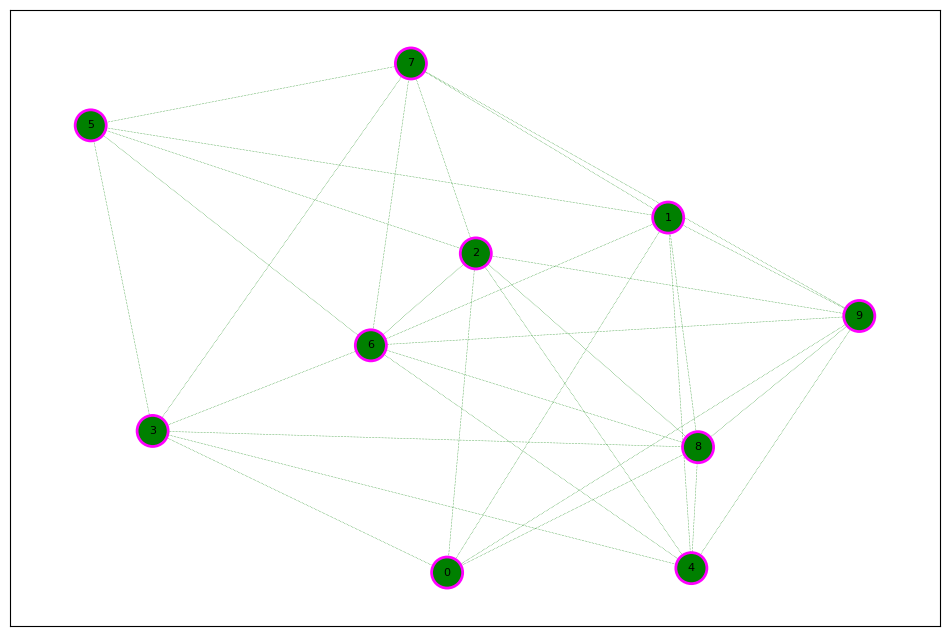

In [69]:
G = nx.fast_gnp_random_graph(10, 0.6)

for (u, v) in G.edges():
    G.edges[u, v]['weight'] = 1

visme(G)

## **Реализация в Pyomo:**



In [70]:
from itertools import product


def get_model(G):
    m = pyo.ConcreteModel()
    m.V = list(G.nodes())
    m.E = [e for e in product(m.V, m.V)]

    m.m = len(m.E)
    m.n = len(m.V)

    m.x = pyo.Var(m.V, domain=pyo.Binary)
    m.y = {e: 0 for e in m.E}
    
    for e in m.y:
        if e in list(G.edges()) or e[0] == e[1]:
            m.y[e] = 1
            m.y[(e[1], e[0])] = 1

    m.clique = pyo.Objective(expr=sum(m.x[v] for v in m.V), sense=pyo.maximize)
    
    @m.Constraint(m.E)
    def вершины_в_клике_только_когда_между_ними_есть_ребро(m, u, v):
        return m.x[u] + m.x[v] <= 1 + m.y[(u, v)]
    
    return m


m = get_model(G)

In [71]:
def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        print(str(v), v.value)

In [72]:
solver = pyo.SolverFactory('cbc')
solver.solve(m).write()
print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 5.0
  Upper bound: 5.0
  Number of objectives: 1
  Number of constraints: 13
  Number of variables: 10
  Number of binary variables: 10
  Number of integer variables: 10
  Number of nonzeros: 10
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
  

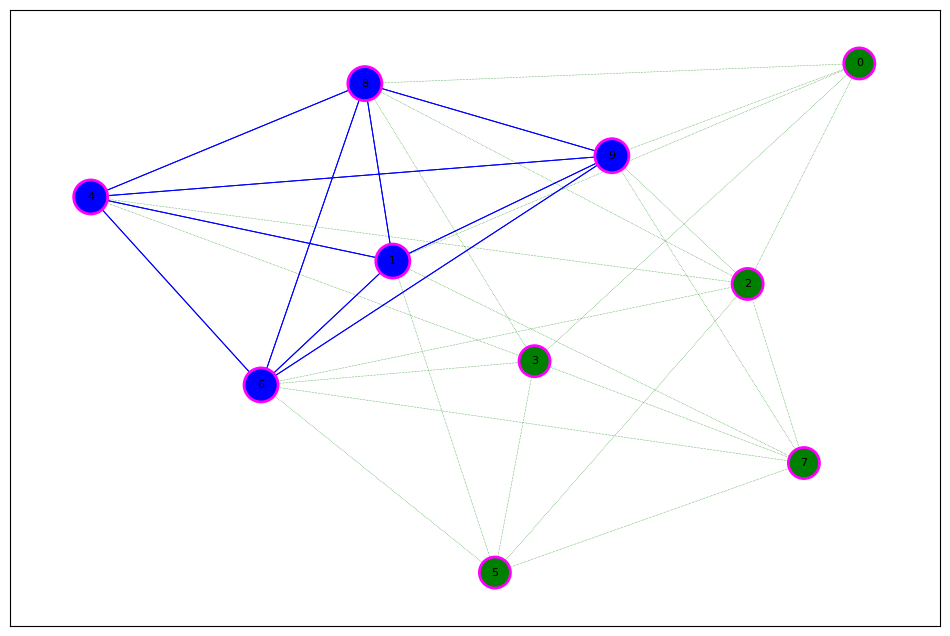

In [73]:
visme(G, m)

## **Сведение 3\-SAT к задаче:**



Пусть дана формула $\Phi$ из $k$ трехбуквенных выражений. 


In [74]:
cnf3 = CNF(from_clauses=psc.rand3cnf(5, 3))
cnf3.clauses

[(2, 1, 3), (-1, 2, -3), (2, -1, 3), (2, -1, 3), (3, -1, 2)]

Построим граф из $k$ кластеров с не более чем $3$ вершинами в каждом кластере. 
* Каждый кластер соответствует скобке в формуле $\Phi$. 
* Ребро ставится между всеми парами вершин в разных кластерах, кроме пар вида $(x, \neg x)$. 
* Рёбер между вершинами из одного кластера в графе нет. 

Тогда граф содержит клику размера не менее $k$ тогда и только тогда, когда формула $\Phi$ разрешима.

In [75]:
def transform_3sat_to_graph(phi):
    # phi: a 3SAT formula with n variables and m clauses

    G = nx.Graph()
    for i, clause in enumerate(phi.clauses):
        for var in clause:
            lit = abs(var)
            node_ = f"x^{i}_{lit}"
            if var < 0:
                node_ = f'\\neg {node_}'
            G.add_node(node_, label=f'${node_}$', clause=i, var=var)  

    for v in G.nodes():
        for u in list(G.nodes()):
            if G.nodes[v]['clause'] != G.nodes[u]['clause']:
                if G.nodes[v]['var'] != -G.nodes[u]['var']:
                    G.add_edge(u, v)
    
    k = len(phi.clauses)

    return G, k

In [76]:
G, _ = transform_3sat_to_graph(cnf3)

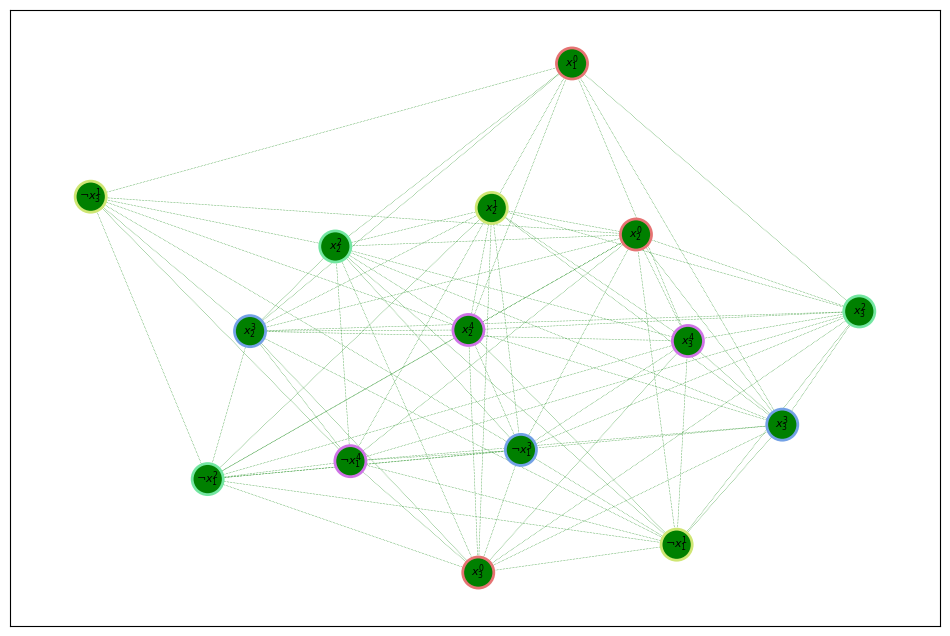

In [77]:
visme(G)

In [78]:
def is_feasible_SAT(cnf3):
    solver = Solver(bootstrap_with=cnf3)
    return solver.solve()

In [79]:
print(is_feasible_SAT(cnf3))

True


In [80]:
def is_feasible_ILP(cnf3):
    G_cnf3, k = transform_3sat_to_graph(cnf3)

    model = get_model(G_cnf3)
    solver = pyo.SolverFactory('cbc')

    solution = solver.solve(model)

    if str(solution['Solver'][0]['Termination condition']) == 'optimal' \
        and model.clique() >= k:
        return True, model
    else:
        return False, None

In [81]:
_, model = is_feasible_ILP(cnf3)
_


True

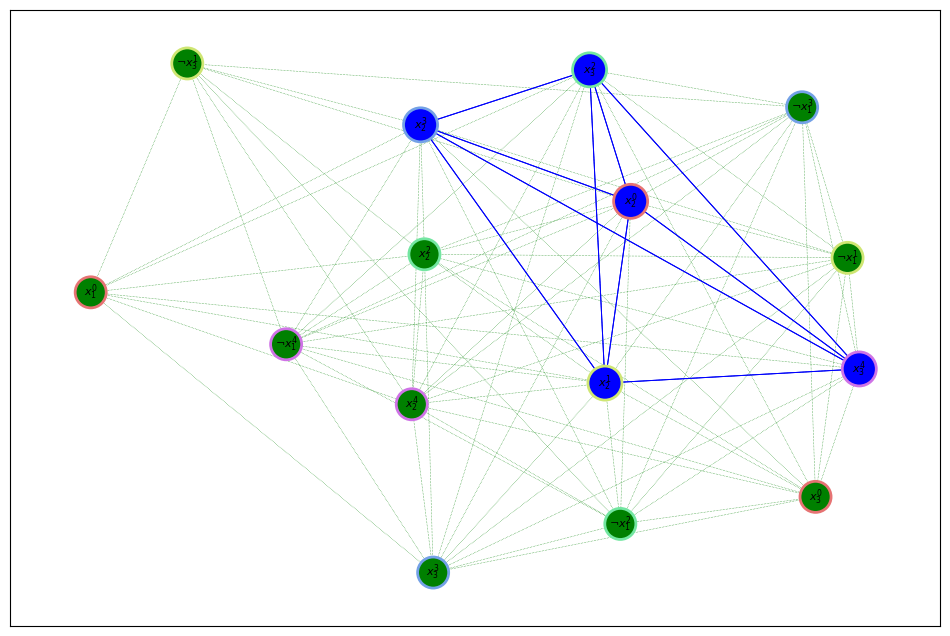

In [82]:

visme(G, model)

## **Генерация тестов:**



In [83]:
def generate_cnf3(max_n, max_k):
    n = randint(1, max_n)
    k = randint(1, max_k)
    cnf3 = CNF(from_clauses=psc.rand3cnf(n, k))
    
    return cnf3

In [86]:
def run_tests(t):
    tests_count_positive = tests_count_negative = 0
    while tests_count_positive < t or tests_count_negative < t:
        cnf3 = generate_cnf3(10, 500)
        is_feasible_SAT_ = is_feasible_SAT(cnf3)
        if is_feasible_SAT_:
            if tests_count_positive >= t:
                continue
            tests_count_positive += 1
        else:    
            if tests_count_negative >= t:
                continue
            tests_count_negative += 1
        is_feasible_ILP_ = is_feasible_ILP(cnf3)[0]
        print(cnf3.nv, len(cnf3.clauses), is_feasible_SAT_, is_feasible_ILP_)
        assert is_feasible_SAT_ == is_feasible_ILP_
    
    print("OK")

In [87]:
run_tests(30)

23 8 True True
15 5 True True
24 9 True True
24 8 True True
15 5 True True
12 4 True True
15 5 True True
24 8 True True
9 3 True True
20 8 True True
28 10 True True
20 7 True True
9 3 True True
6 2 True True
26 9 True True
27 9 True True
9 3 True True
16 7 True True
17 6 True True
12 4 True True
9 3 True True
12 4 True True
12 4 True True
28 10 True True
12 6 True True
18 7 True True
3 1 True True
29 10 True True
28 10 True True
21 7 True True
2 9 False False
2 10 False False
1 3 False False
1 10 False False
2 5 False False
1 7 False False
2 8 False False
2 8 False False
2 10 False False
1 5 False False
1 8 False False
2 10 False False
1 7 False False
1 10 False False
1 9 False False
2 6 False False
1 3 False False
2 8 False False
2 10 False False
1 9 False False
2 8 False False
2 9 False False
1 2 False False
1 4 False False
1 10 False False
1 10 False False
2 6 False False
2 7 False False
1 10 False False
2 8 False False
OK
